In [3]:
import pandas
import numpy 
import seaborn
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

import tensorflow as tf
from tensorflow import keras

import plotly.io as pio
pio.renderers.default = "png"

In [4]:
df = pandas.read_csv("./data/train.csv")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [5]:
df["Order Date"] = pandas.to_datetime(df["Order Date"], infer_datetime_format=True)
df["Ship Date"] = pandas.to_datetime(df["Ship Date"], infer_datetime_format=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9800 non-null   int64         
 1   Order ID       9800 non-null   object        
 2   Order Date     9800 non-null   datetime64[ns]
 3   Ship Date      9800 non-null   datetime64[ns]
 4   Ship Mode      9800 non-null   object        
 5   Customer ID    9800 non-null   object        
 6   Customer Name  9800 non-null   object        
 7   Segment        9800 non-null   object        
 8   Country        9800 non-null   object        
 9   City           9800 non-null   object        
 10  State          9800 non-null   object        
 11  Postal Code    9789 non-null   float64       
 12  Region         9800 non-null   object        
 13  Product ID     9800 non-null   object        
 14  Category       9800 non-null   object        
 15  Sub-Category   9800 n

In [7]:
# Identifying missing/null values

missing_values = df.isnull()
for cols in missing_values.columns:
    print(cols,': ', end="")
    print(missing_values[cols].value_counts())

Row ID : False    9800
Name: Row ID, dtype: int64
Order ID : False    9800
Name: Order ID, dtype: int64
Order Date : False    9800
Name: Order Date, dtype: int64
Ship Date : False    9800
Name: Ship Date, dtype: int64
Ship Mode : False    9800
Name: Ship Mode, dtype: int64
Customer ID : False    9800
Name: Customer ID, dtype: int64
Customer Name : False    9800
Name: Customer Name, dtype: int64
Segment : False    9800
Name: Segment, dtype: int64
Country : False    9800
Name: Country, dtype: int64
City : False    9800
Name: City, dtype: int64
State : False    9800
Name: State, dtype: int64
Postal Code : False    9789
True       11
Name: Postal Code, dtype: int64
Region : False    9800
Name: Region, dtype: int64
Product ID : False    9800
Name: Product ID, dtype: int64
Category : False    9800
Name: Category, dtype: int64
Sub-Category : False    9800
Name: Sub-Category, dtype: int64
Product Name : False    9800
Name: Product Name, dtype: int64
Sales : False    9800
Name: Sales, dtype: in

In [8]:
df.describe(include="all", datetime_is_numeric=True)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
count,9800.000000,9800,9800,9800,9800,9800,9800,9800,9800,9800,9800,9789.000000,9800,9800,9800,9800,9800,9800.000000
unique,NaN,4922,NaN,NaN,4,793,793,3,1,529,49,NaN,4,1861,3,17,1849,NaN
top,NaN,CA-2018-100111,NaN,NaN,Standard Class,WB-21850,William Brown,Consumer,United States,New York City,California,NaN,West,OFF-PA-10001970,Office Supplies,Binders,Staple envelope,NaN
freq,NaN,14,NaN,NaN,5859,35,35,5101,9800,891,1946,NaN,3140,19,5909,1492,47,NaN
mean,4900.500000,NaN,2017-04-12 14:24:35.265306368,2017-04-21 19:45:12.489796096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55273.322403,NaN,NaN,NaN,NaN,NaN,230.769059
min,1.000000,NaN,2015-01-02 00:00:00,2015-01-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1040.000000,NaN,NaN,NaN,NaN,NaN,0.444000
25%,2450.750000,NaN,2016-05-02 12:00:00,2016-05-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23223.000000,NaN,NaN,NaN,NaN,NaN,17.248000
50%,4900.500000,NaN,2017-05-30 00:00:00,2017-06-12 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58103.000000,NaN,NaN,NaN,NaN,NaN,54.490000
75%,7350.250000,NaN,2018-04-11 00:00:00,2018-05-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90008.000000,NaN,NaN,NaN,NaN,NaN,210.605000
max,9800.000000,NaN,2018-12-30 00:00:00,2019-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99301.000000,NaN,NaN,NaN,NaN,NaN,22638.480000


In [9]:
size_by_state = df["State"].value_counts().to_frame()
size_by_state.reset_index(inplace=True)
size_by_state.columns = ["States", "Counts"]
size_by_state.sort_values(by="Counts", ascending=False, inplace=True)

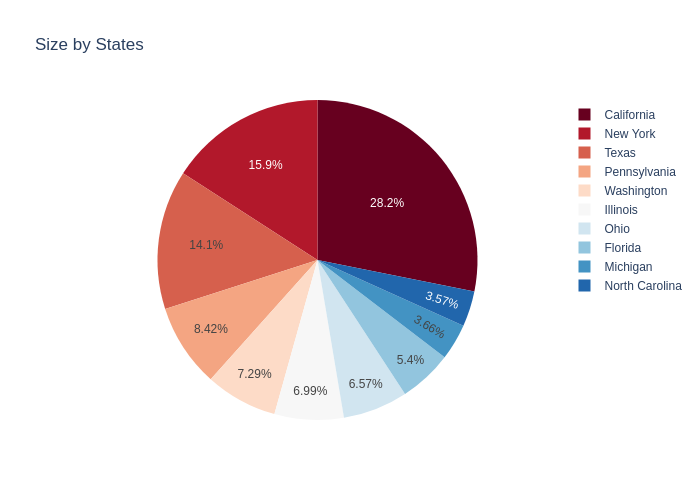

In [10]:

fig = px.pie(size_by_state[:10], 
             values='Counts', 
             names='States', 
             title='Size by States',
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

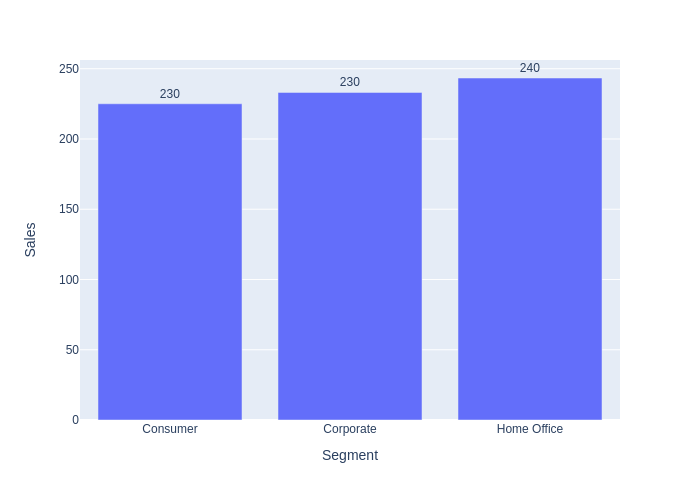

In [11]:
sales_by_segment = df.groupby("Segment")["Sales"].mean().to_frame()
sales_by_segment.reset_index(inplace=True)

fig = px.bar(sales_by_segment,
            x="Segment",
            y="Sales",
            text="Sales")
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

In [12]:
segement_by_category = df.groupby(["Segment", "Sub-Category"])["Sales"].sum().to_frame()
segement_by_category.reset_index(inplace=True)

In [13]:
segement_by_category.head()

,Segment,Sub-Category,Sales
0,Consumer,Accessories,85699.074
1,Consumer,Appliances,52367.233
2,Consumer,Art,14062.256
3,Consumer,Binders,117091.909
4,Consumer,Bookcases,67949.397


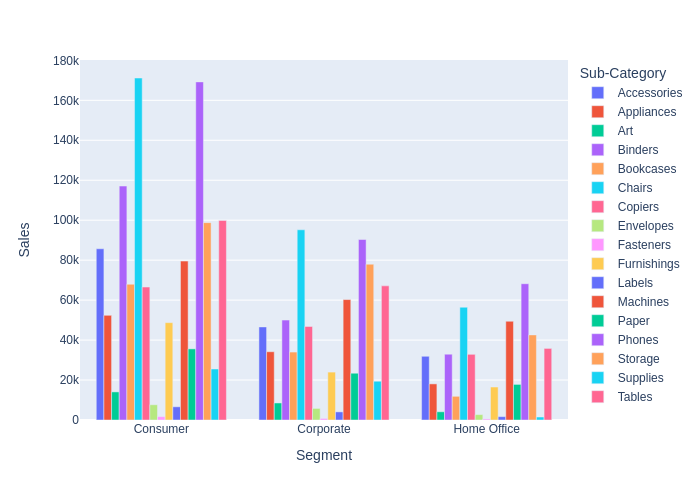

In [14]:
fig = px.bar(segement_by_category,
            x="Segment",
            y="Sales",
            barmode="group",
            color="Sub-Category")
fig.show()

In [15]:
ordertime_by_sales = df[["Order Date", "Sales"]]
ordertime_by_sales.set_index(keys="Order Date", inplace=True)

In [16]:
order_per_day = ordertime_by_sales.resample("D").sum()

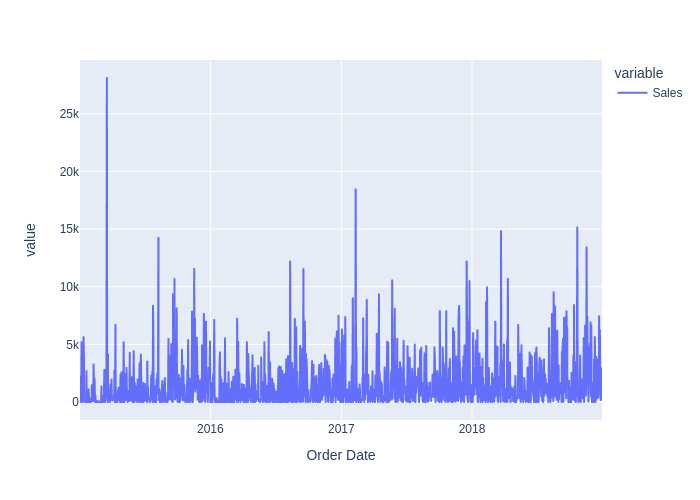

In [17]:
fig = px.line(order_per_day)
fig.show()

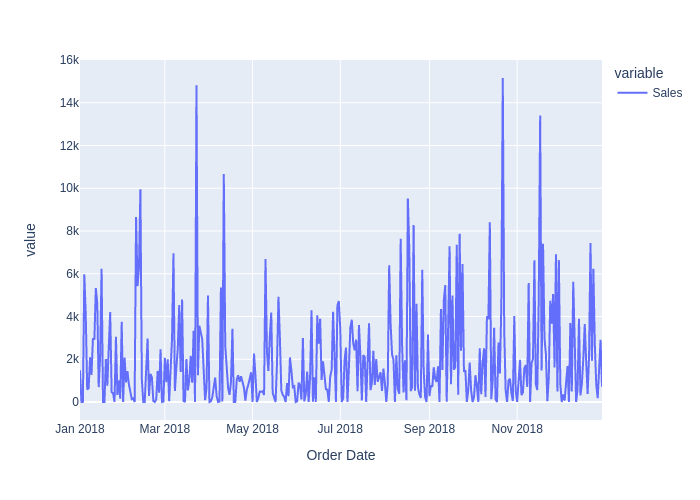

In [18]:
fig = px.line(order_per_day.loc["2018"])
fig.show()

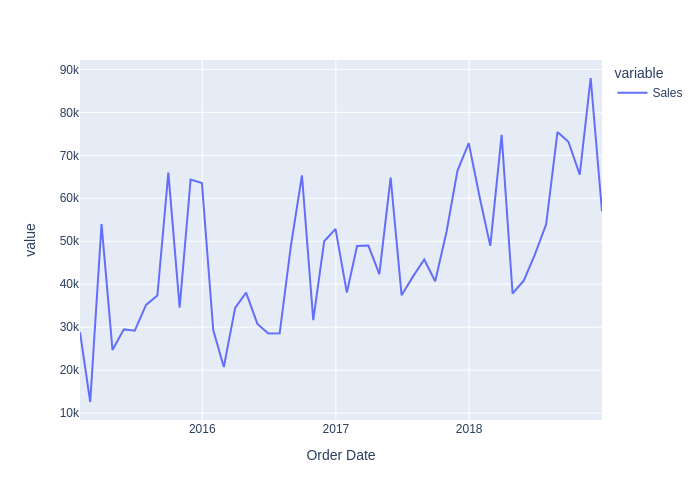

In [19]:
order_per_Month = ordertime_by_sales.resample("M").sum()
fig = px.line(order_per_Month)
fig.show()

In [20]:
df["order_year"] = df["Order Date"].dt.year
df["order_month"] = df["Order Date"].dt.month
df["order_wek"] = df["Order Date"].dt.isocalendar().week

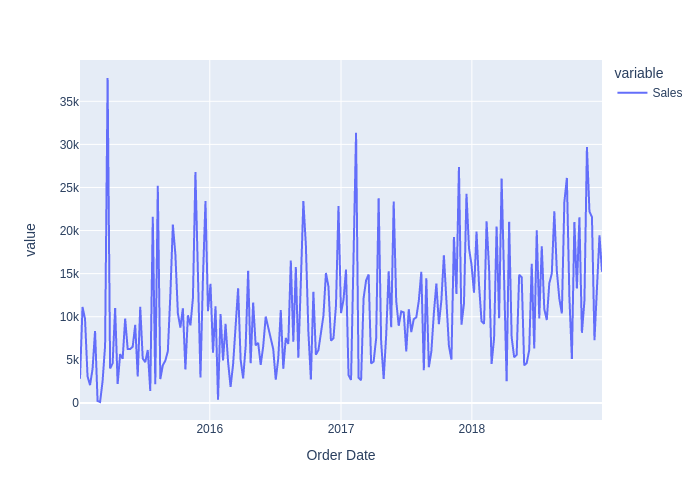

In [21]:
order_per_week = ordertime_by_sales.resample("W").sum()
fig = px.line(order_per_week)
fig.show()

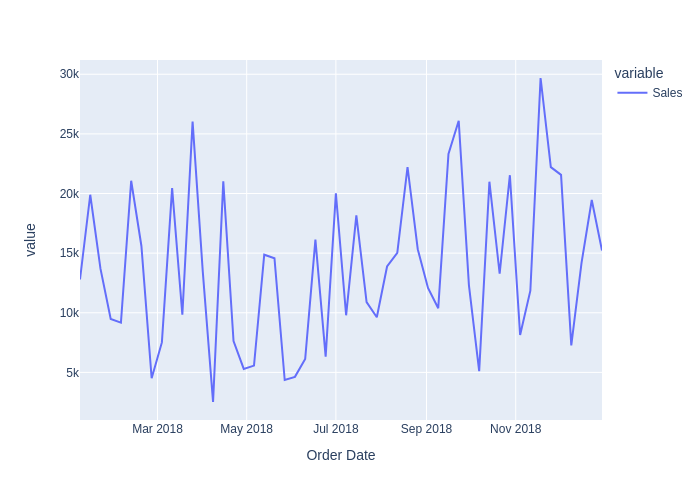

In [22]:
order_by_year = ordertime_by_sales.resample("W").sum()
fig = px.line(order_by_year.loc["2018"])
fig.show()

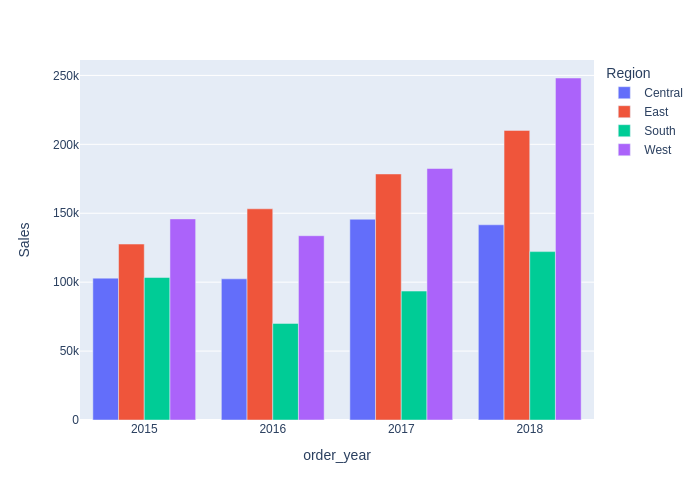

In [23]:
sales_by_region = df.groupby(["order_year", "Region"])["Sales"].sum().to_frame()
sales_by_region.reset_index(inplace=True)
fig = px.bar(sales_by_region,
            x="order_year",
            y="Sales",
            barmode="group",
            color="Region")
fig.show()

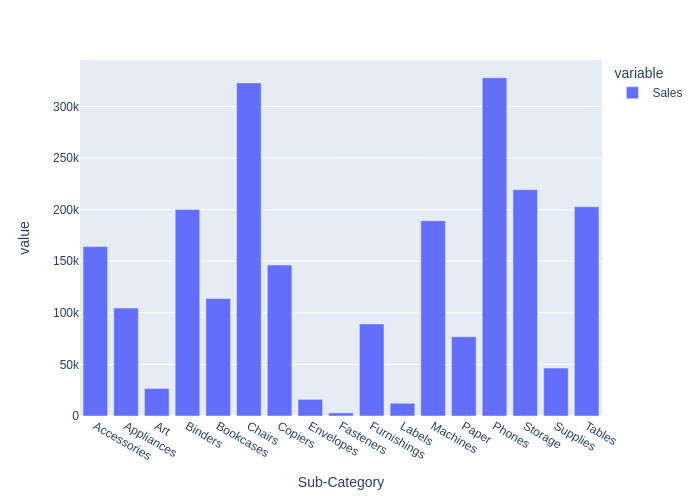

In [24]:
sales_by_subcat = df.groupby("Sub-Category")["Sales"].sum()
fig = px.bar(sales_by_subcat)
fig.show()

In [25]:
counts_by_subcat = df["Sub-Category"].value_counts().to_frame()
counts_by_subcat.reset_index(inplace=True)
counts_by_subcat.columns = ["Sub-Category", "Frequency"]

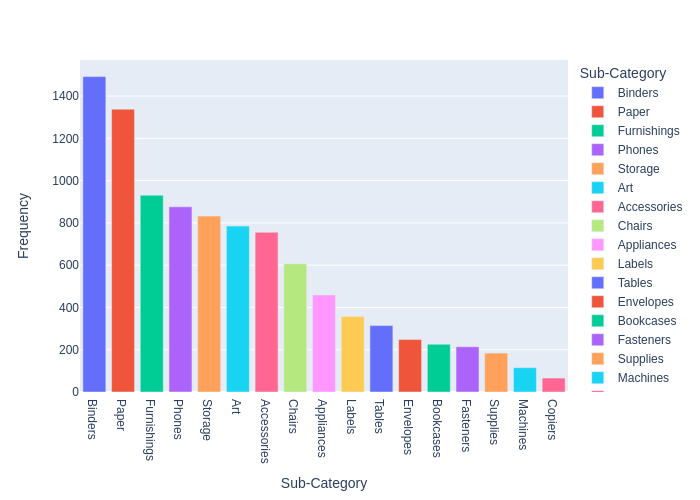

In [26]:
fig = px.bar(counts_by_subcat, 
             x='Sub-Category', 
             y='Frequency',
             color='Sub-Category')
fig.show()

In [27]:
counts_by_cat = df["Category"].value_counts().to_frame()
counts_by_cat.reset_index(inplace=True)
counts_by_cat.columns = ["Category", "Frequency"]

In [28]:
counts_by_cat

,Category,Frequency
0,Office Supplies,5909
1,Furniture,2078
2,Technology,1813


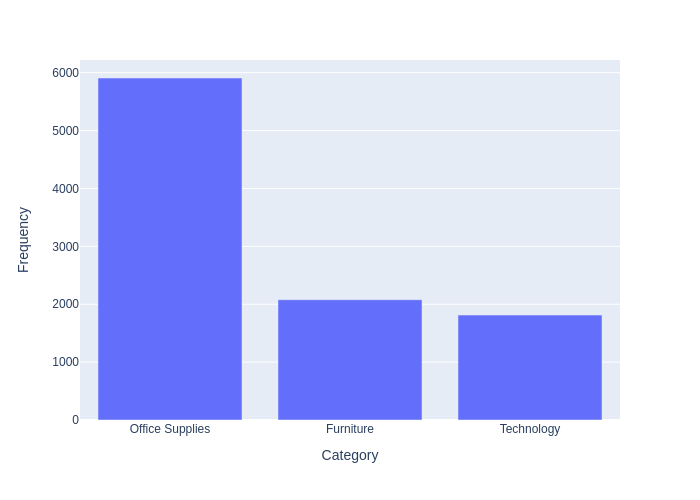

In [29]:
fig = px.bar(counts_by_cat, 
             x='Category', 
             y='Frequency'
             )
fig.show()

### Model Development

In [30]:
order_per_week = order_per_Month.copy()
order_per_week.fillna(0, inplace=True)
train_size = int(len(order_per_week) * 0.7)
train_set = order_per_week[: train_size]
test_set = order_per_week[train_size:]

In [31]:
train_set.info(), test_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33 entries, 2015-01-31 to 2017-09-30
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   33 non-null     float64
dtypes: float64(1)
memory usage: 528.0 bytes
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15 entries, 2017-10-31 to 2018-12-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   15 non-null     float64
dtypes: float64(1)
memory usage: 240.0 bytes


(None, None)

In [32]:
train_set.shape, test_set.shape

((33, 1), (15, 1))

### Naive Model

Building a persistence model this will identify a base error for subsequent Models

In [33]:
def naive_model(history):
    return history[-1]

In [34]:
def forecast_model(model, X:pandas.DataFrame, y: pandas.DataFrame):
    predictions = list()
    history = [x for x in X.values]
    for p in range(len(y.values)):
        yhat = model(history=history)
        predictions.append(yhat)
        history.append(y.values[p])
    rmse = numpy.sqrt(mean_squared_error(y.values, predictions))
    return rmse, predictions

In [35]:
rmse, naive_predictions = forecast_model(model=naive_model, X=train_set, y=test_set)

In [36]:
rmse

17853.899819244652

In [37]:
naive_predictions = numpy.array(naive_predictions)

In [38]:
naive_predictions = naive_predictions.reshape((naive_predictions.shape[0],))
naive_predictions.shape

(15,)

In [39]:
naive_test = test_set.copy()
naive_test.loc[:,"naive"] = naive_predictions

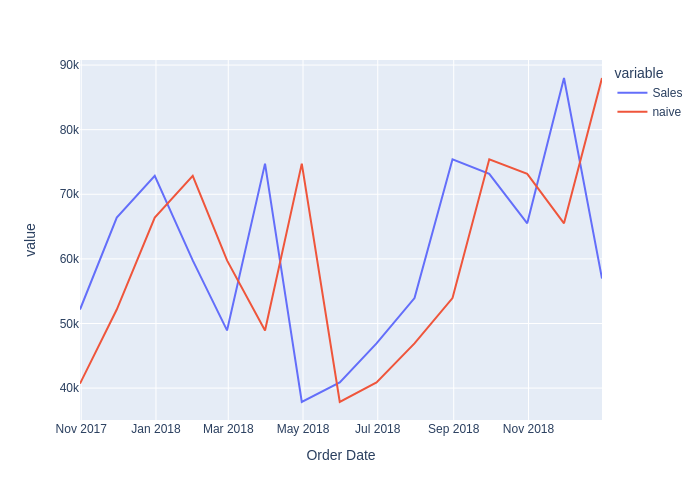

In [40]:
fig = px.line(naive_test)
fig.show()

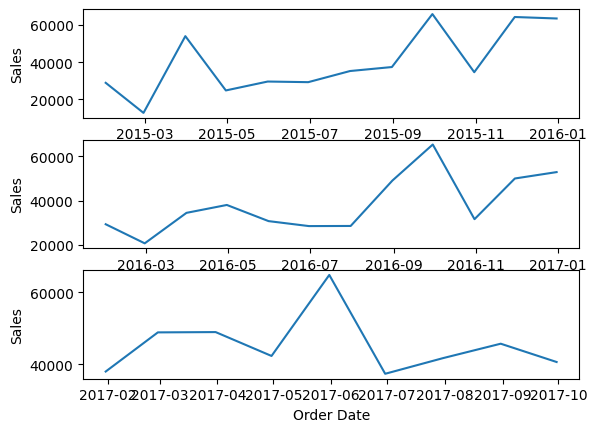

In [41]:
groups = train_set.Sales['2015':'2017'].groupby(pandas.Grouper(freq='A'))
years = pandas.DataFrame()
plt.figure()
i = 1
n_groups = len(groups)
for name, group in groups:
    plt.subplot((n_groups*100) + 10 + i)
    i += 1
    seaborn.lineplot(group)
plt.show()

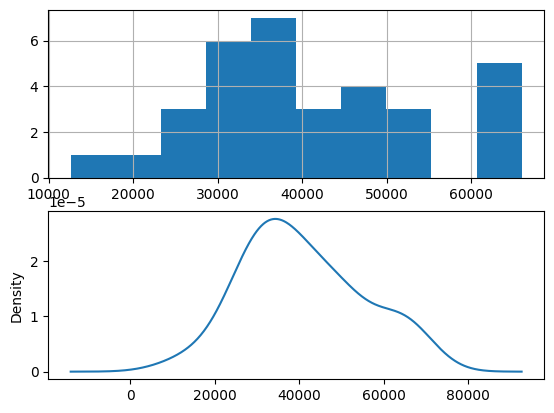

In [42]:
plt.figure(1)
plt.subplot(211)
train_set.Sales.hist()
plt.subplot(212)
train_set.Sales.plot(kind='kde')
plt.show()

In [43]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pandas.Series(diff)

def inverse_difference(history, yhat, interval):
    return yhat + history[-interval]

In [44]:
train_df = train_set.squeeze()
train_df = train_df.values
train_df = train_df.astype("float32")

test_df = test_set.squeeze()
test_df = test_df.values
test_df = test_df.astype("float32")

In [45]:
day_in_year = 12
stationary = difference(train_df, day_in_year)

ADF Statistic: -3.079241
p-value: 0.028128
Critical Values:
	1%: -3.809
	5%: -3.022
	10%: -2.651


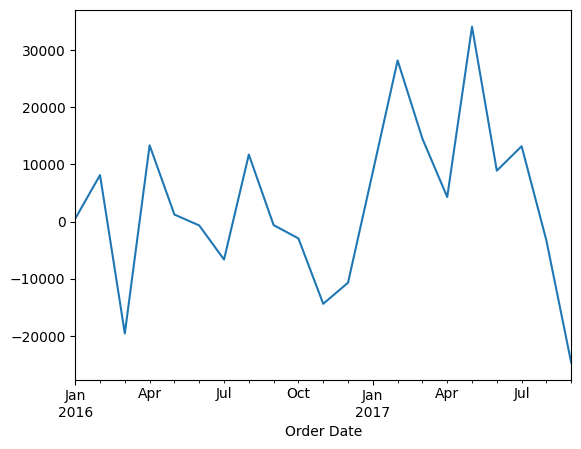

In [46]:
day_in_year = 12
stationary = difference(train_df, day_in_year)
stationary.index = train_set.index[day_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv', header=False)
# plot
stationary.plot()
plt.show()

/home/vhyne/anaconda3/envs/TF-py/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



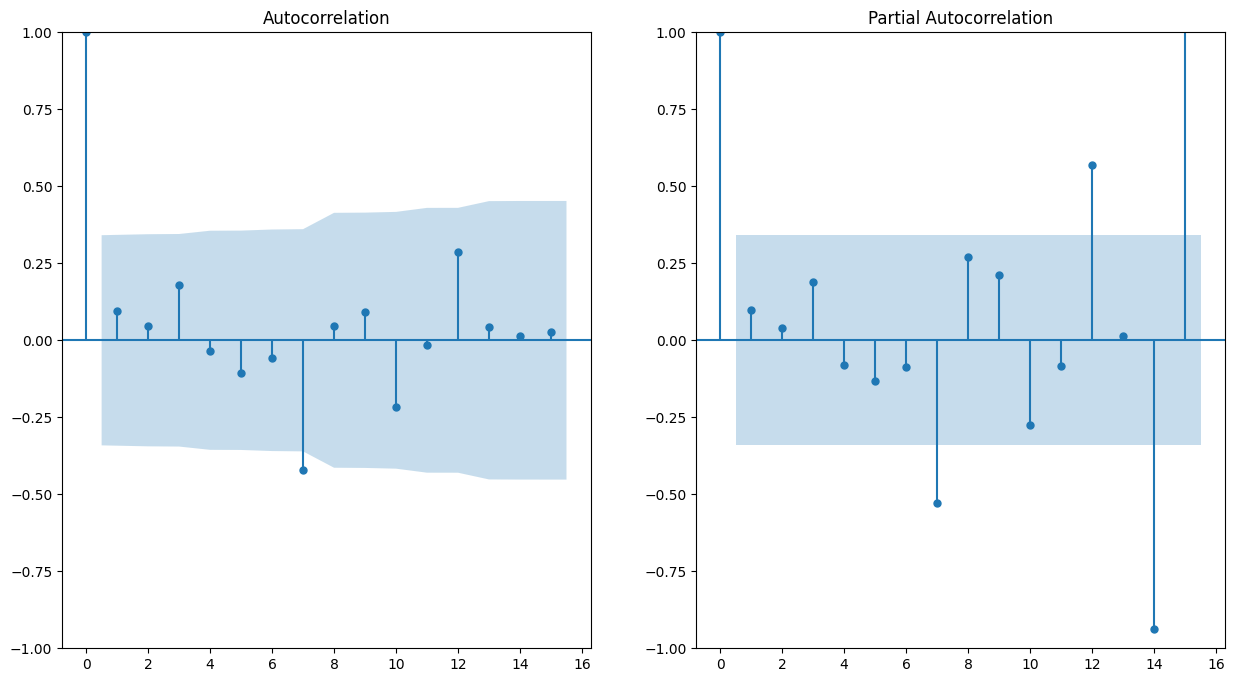

In [47]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plot_acf(train_df, lags=15, ax=plt.gca())
plt.subplot(1,2,2)
plot_pacf(train_df, lags=15, ax=plt.gca())
plt.show()

In [48]:
test_df.shape, train_df.shape

((15,), (33,))

In [49]:
def arima_forecast(history):
    history = numpy.array(history)
    history = history.reshape((history.shape[0],))
    stationary = difference(history, day_in_year)
    arima_model = ARIMA(stationary, order=(4,0,1))
    arima_model_fit = arima_model.fit()
    yhat = arima_model_fit.forecast()
    yhat = inverse_difference(history, yhat, day_in_year)
    return yhat

In [50]:
# history = [x for x in train_set.values]
# history = numpy.array(history)
# history = history.astype("float32")
# history = history.reshape((history.shape[0],))

# arima_predictions = list()
# history = [x for x in train_df]
# for p in range(len(test_df)):
#     stationary = difference(history, day_in_year)
#     arima_model = ARIMA(stationary, order=(1,0,1))
#     arima_model_fit = arima_model.fit()
#     yhat = arima_model_fit.forecast()
#     yhat = inverse_difference(history, yhat, 52)
#     arima_predictions.append(yhat.values)
#     history.append(test_df[p])
# rmse = numpy.sqrt(mean_squared_error(test_df, arima_predictions))

In [51]:
rmse, arima_predictions = forecast_model(model=arima_forecast, X=train_set, y=test_set)

In [52]:
rmse

17478.428976834675

In [53]:
arima_predictions = numpy.array(arima_predictions)
arima_predictions = arima_predictions.reshape((arima_predictions.shape[0],))

In [54]:
arima_predictions.shape

(15,)

In [55]:
arima_test = test_set.copy()
arima_test.loc[:,"arima"] = arima_predictions

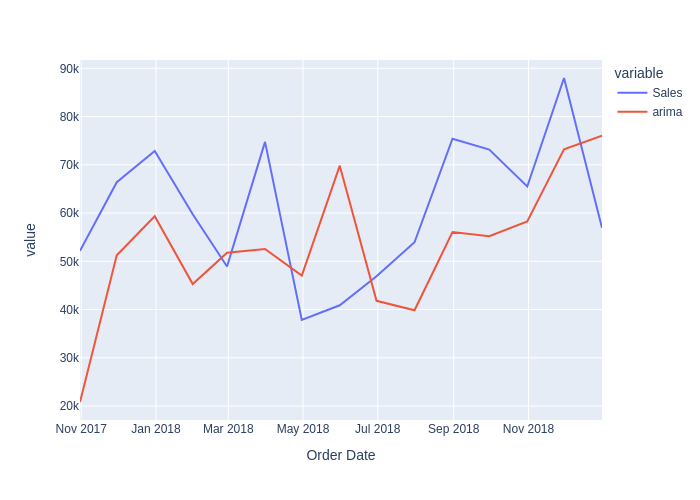

In [56]:
fig = px.line(arima_test)
fig.show()

In [58]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(train_set['Sales'], autolag='AIC')

dfoutput = pandas.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                 -5.034237
p-value                         0.000019
#Lags Used                      0.000000
Number of Observations Used    32.000000
Critical Value (1%)            -3.653520
Critical Value (5%)            -2.957219
Critical Value (10%)           -2.617588
dtype: float64


In [59]:
ARIMA_model = pm.auto_arima(train_set['Sales'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

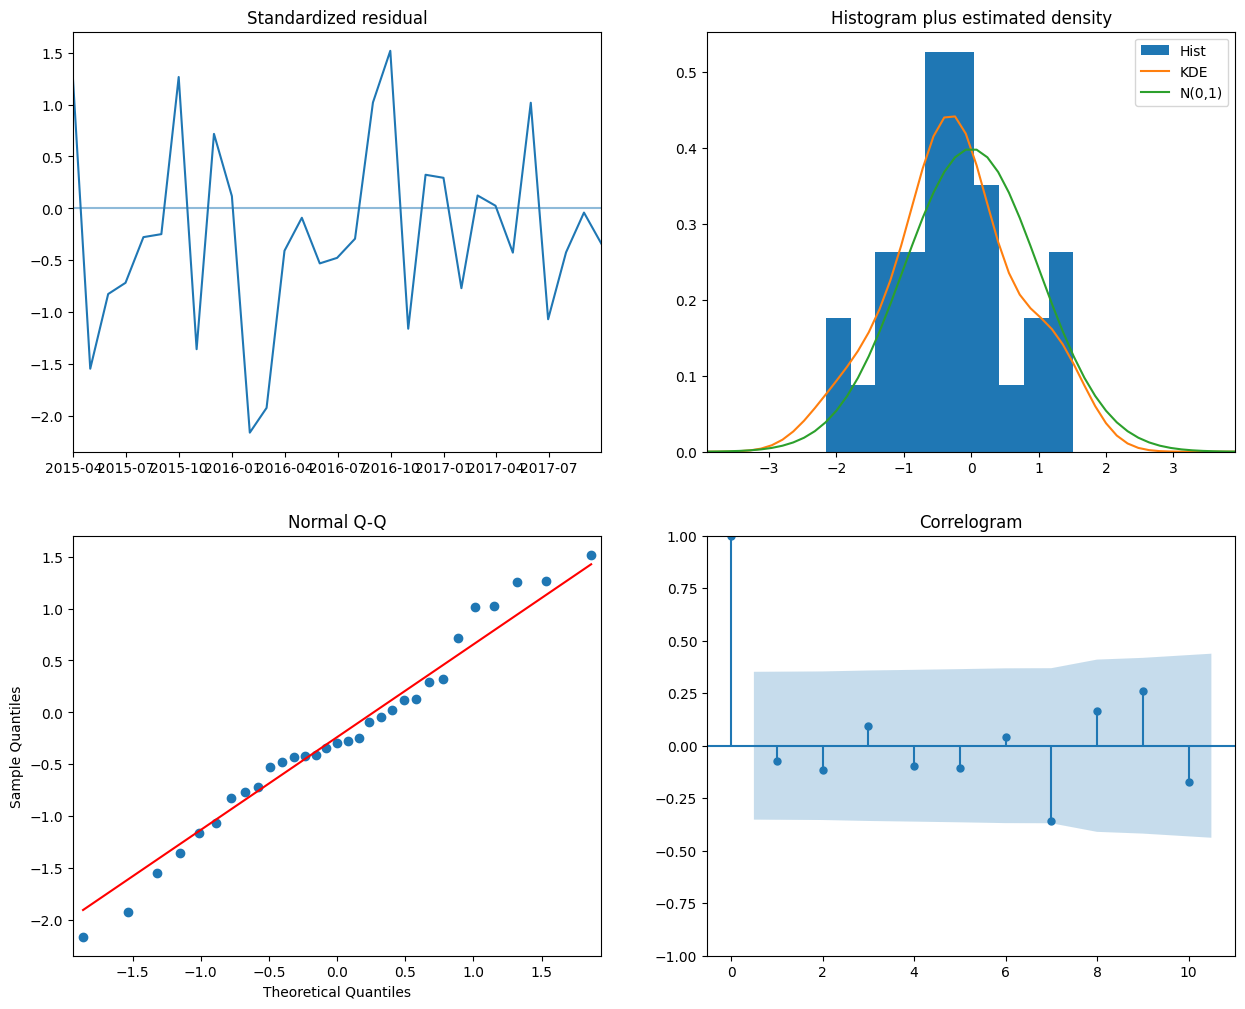

In [60]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [68]:
def forecast(ARIMA_model, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pandas.date_range(train_set.index[-1] + pandas.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pandas.Series(fitted, index=index_of_fc)
    lower_series = pandas.Series(confint[:, 0], index=index_of_fc)
    upper_series = pandas.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(train_set["Sales"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Sales For SuperStore")
    plt.show()
    return fitted

# fitted = forecast(ARIMA_model)

In [63]:
SARIMA_model = pm.auto_arima(train_set["Sales"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=3, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

## Univariate LSTM

In [57]:
daily_sales = order_per_day.resample("D").sum()
daily_sales.fillna(0, inplace=True)

In [59]:
train_x = daily_sales.loc["2015-01-04": "2017-12-30"]
val_x = daily_sales.loc["2017-12-31": "2018-12-29"]
train_x = numpy.array(numpy.split(train_x, (len(train_x)/7)))
val_x = numpy.array(numpy.split(val_x, (len(val_x)/7)))

In [60]:
train_x.shape, val_x.shape

((156, 7, 1), (52, 7, 1))

In [82]:
def reshape_nn_input(x: numpy, n_input: int, n_output):
    data = x.reshape((x.shape[0] * x.shape[1], x.shape[2]))
    X, y = list(), list()
    first_index = 0
    for _ in range(len(data)):
        in_len = first_index + n_input
        target_len = in_len + n_output
        if target_len <= len(data):
            x_input = data[first_index:in_len, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_len:target_len, 0])
        first_index += 1
    return numpy.array(X), numpy.array(y)

In [90]:
x_train, y_train = reshape_nn_input(x=train_x, n_input=28, n_output=7)
x_train.shape, y_train.shape

((1058, 28, 1), (1058, 7))

In [142]:
def lstm_model(x: numpy, y: numpy):
    timestamps, features, num_outputs = x.shape[1], x.shape[2], y.shape[1]
    model = keras.Sequential()
    model.add(keras.layers.LSTM(200, activation='relu', input_shape=(timestamps, features)))
    model.add(keras.layers.Dense(100, activation=keras.activations.relu))
    model.add(keras.layers.Dense(50, activation=keras.activations.relu))
    model.add(keras.layers.Dense(num_outputs))

    model.compile(
        loss=keras.losses.mean_squared_error,
        optimizer=keras.optimizers.Adam()
    )
    history = model.fit(x, y, epochs=50, batch_size=16, verbose=2)
    return history, model

In [143]:
history, model = lstm_model(x_train, y_train)

Epoch 1/50
67/67 - 2s - loss: 5448150.0000 - 2s/epoch - 36ms/step
Epoch 2/50
67/67 - 1s - loss: 5047040.5000 - 1s/epoch - 18ms/step
Epoch 3/50
67/67 - 1s - loss: 5608065.0000 - 1s/epoch - 16ms/step
Epoch 4/50
67/67 - 1s - loss: 6189234.5000 - 1s/epoch - 18ms/step
Epoch 5/50
67/67 - 1s - loss: 5321102.0000 - 1s/epoch - 18ms/step
Epoch 6/50
67/67 - 1s - loss: 5080064.0000 - 1s/epoch - 18ms/step
Epoch 7/50
67/67 - 1s - loss: 5046554.0000 - 1s/epoch - 16ms/step
Epoch 8/50
67/67 - 1s - loss: 5170791.0000 - 1s/epoch - 16ms/step
Epoch 9/50
67/67 - 1s - loss: 5017233.5000 - 1s/epoch - 20ms/step
Epoch 10/50
67/67 - 2s - loss: 5000470.0000 - 2s/epoch - 26ms/step
Epoch 11/50
67/67 - 1s - loss: 4976189.0000 - 1s/epoch - 20ms/step
Epoch 12/50
67/67 - 1s - loss: 5191148.5000 - 1s/epoch - 19ms/step
Epoch 13/50
67/67 - 1s - loss: 5091568.5000 - 1s/epoch - 20ms/step
Epoch 14/50
67/67 - 1s - loss: 5025603.5000 - 1s/epoch - 17ms/step
Epoch 15/50
67/67 - 1s - loss: 5110796.0000 - 1s/epoch - 22ms/step
Epoc

In [144]:
def model_prediction(model, x: numpy, n_inputs=7):
    # data = x.reshape((x.shape[0] * x.shape[1], x.shape[2]))
    # print(data.shape)

    last_week = x[-4:]
    print(last_week.shape)
    last_week = last_week.reshape((1,last_week.shape[0] * last_week.shape[1], 1))
    yhat = model.predict(last_week, verbose=1)

    return yhat

In [145]:
train_x[-2:].shape

(2, 7, 1)

In [146]:
yhat = model_prediction(model=model, x=train_x)

(4, 7, 1)
1/1 [==============================] - 0s 220ms/step


In [147]:
def flatten_shape(array: numpy):
    array_multiplication = array.shape[0] * array.shape[1]
    return numpy.reshape(array, (array_multiplication,))

In [148]:
yhat_values = flatten_shape(yhat)
yhat_values.shape

In [150]:
yhat

array([[1821.9006, 1891.9735, 1839.6724, 1798.0387, 1898.8197, 1913.4539,
        1918.7028]], dtype=float32)

In [116]:
x = [x for x in train_x[:3]]
x[-1:][0].shape

(7, 1)

In [158]:
def model_prediction(model, x: numpy, n_inputs=7):
    data = numpy.array(x)
    data = data.reshape((data.shape[0] * data.shape[1], data.shape[2]))

    last_week = data[-4:]
    last_week = last_week.reshape((1,last_week.shape[0] * last_week.shape[1], 1))
    yhat = model.predict(last_week, verbose=1)

    return yhat

def evaluate_model(model, train, test):
    history = [obs for obs in train]
    predictions = list()

    for v in range(len(test)):
        yhat = model_prediction(model=model, x=history)
        predictions.append(yhat)
        history.append(test[v, :])
    predictions = numpy.array(predictions)
    return predictions

In [159]:
prediction_lstm = evaluate_model(model, train_x, val_x)

1/1 [==============================] - 0s 24ms/step


In [160]:
prediction_lstm_reshape = prediction_lstm.reshape((prediction_lstm.shape[0] * prediction_lstm.shape[2],))
prediction_lstm_reshape.shape

(364,)

In [161]:
valid_reshape = val_x.reshape((val_x.shape[0] * val_x.shape[1],))
valid_reshape.shape

(364,)

In [162]:
valid_reshape[:10]

array([ 731.768, 1481.828,    0.   ,    0.   , 5972.988, 4108.37 ,
        586.042,  639.83 , 2085.65 , 1261.81 ])

In [138]:
rmse = numpy.sqrt(mean_squared_error(valid_reshape, prediction_lstm_reshape))
rmse

2938.2744526332212

In [140]:
lstm_predicition_df = pandas.DataFrame({"Real": valid_reshape, "Predicted": prediction_lstm_reshape})
lstm_predicition_df.head()

,Real,Predicted
0,731.768,128.994431
1,1481.828,125.518158
2,0.000,114.847755
3,0.000,72.738472
4,5972.988,88.677849
